In [1]:
#conv Neural Network
# tensorboard --logdir=/home/ncc/notebook/learn/tensorboard/log
"""
created by kim Seong jung

"""
import numpy as np 
import tensorflow as tf
import re

import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
import os 

file_locate='/media/seongjung/Seagate Backup Plus Drive/data/ASAN/numpy/64/'
sess = tf.InteractiveSession()
test_img=np.load(file_locate+'test_img.npy');
try:
    print np.shape(test_img)
    img_row = np.shape(test_img)[1]
    img_col = np.shape(test_img)[2]
except:
    np.shape(test_img)
    test_img=np.reshape(test_img , newshape = [np.shape(test_img)[0] , 32, 32 ,3] )
    img_row = np.shape(test_img)[1]
    img_col = np.shape(test_img)[2]

    
divide_flag= False
batch_size=30
print img_row ,img_col
n_classes =2
in_ch =3
out_ch1=200
out_ch2=200
out_ch3=200
out_ch4=200
out_ch5=200


fully_ch1=1024
fully_ch2 =1024
fully_ch3 =1024



strides_1=[1,2,2,1]
strides_2=[1,1,1,1]
strides_3=[1,1,1,1]
strides_4=[1,1,1,1]
strides_5=[1,1,1,1]


x= tf.placeholder("float",shape=[None,img_col , img_row , 3],  name = 'x-input')
y_=tf.placeholder("float",shape=[None , n_classes] , name = 'y-input')
keep_prob = tf.placeholder("float")

x_image= tf.reshape(x,[-1,img_row,img_col,3])

iterate=100



weight_row =3 ; weight_col=3

pooling_row_size1=int(img_row/2)
pooling_row_size2=int(pooling_row_size1/2)
pooling_row_size3=int(pooling_row_size2/2)
pooling_row_size4=int(pooling_row_size3/2)
pooling_row_size5=int(pooling_row_size4/2)
pooling_col_size1=int(img_col/2)
pooling_col_size2=int(pooling_col_size1/2)
pooling_col_size3=int(pooling_col_size2/2)
pooling_col_size4=int(pooling_col_size3/2)
pooling_col_size5=int(pooling_col_size4/2)

print img_col , img_row

(197, 64, 64, 3)
64 64
64 64


# Restore Weight and Bias

In [2]:
restore_flag =True
if restore_flag ==True:
    restore_path='/home/seongjung/variable_save'

In [3]:
def aug(np_img ,crop_img_row , crop_img_col , label):
    """
    np_img must 4D 
    np_img shape : n , row , col , color_ch
    
    """
    n_img,img_row,img_col,color_ch=np.shape(np_img)
    n_ret_img = n_img*(img_row - crop_img_row) * (img_col - crop_img_col)*2
    ret_images = np.zeros([n_ret_img ,crop_img_row , crop_img_col,color_ch])
    len_label= np.shape(label)[1]
    ret_labels =  np.zeros([n_ret_img  ,len_label])
    #print "n_augmented image size : " , n_ret_img 
    #print "n classes :", len_label
    #copy label in factor by 2014
    count=0
    if len(np.shape(np_img))==2:
        np_img=np.reshape(np_img , newshape = [np.shape(np_img)[0] , img_row , img_col ,color_ch])
        print np.shape(np_img)
    for n  in range(0,n_img):
        for r in range(img_row - crop_img_row):
            for c in range(img_col - crop_img_col):
                cropped_img = np_img[n, r:crop_img_row +r , c:crop_img_col+c ,: ]
                ret_images[count*2,:,:,:]=cropped_img  
                ret_images[(count*2+1) , :,:,:] =np.fliplr(cropped_img )
                ret_labels[count*2 , : ] = label[n,:]
                ret_labels[count*2+1 , : ] = label[n,:]
                count+=1
    return ret_images ,ret_labels



In [4]:
a=[1,2,3]
b=[2,3,4]
c=[a,b]
del a
del b
print c

[[1, 2, 3], [2, 3, 4]]


In [5]:
import os 
os.getcwd()

'/home/seongjung/jupyter'

In [6]:
with tf.device('/gpu:0'):
#with tf.device('/gpu:0'):

    if divide_flag == False:
        train_img=np.load(file_locate+'train_img.npy');
        train_lab=np.load(file_locate+'train_lab.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "val Data Label" , np.shape(val_img)

        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]

    if divide_flag == True:
        train_img=np.load(file_locate+'train_img_1.npy');
        train_lab=np.load(file_locate+'train_lab_1.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "val Data Label" , np.shape(val_lab)

        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]


Training Data (1570, 64, 64, 3)
Training Data Label (1570, 2)
Test Data Label (197, 2)
val Data Label (196, 64, 64, 3)


In [7]:
"""def weight_variable(name,shape):
    #initial = tf.truncated_normal(shape , stddev=0.1)
    initial = tf.get_variable(name,shape=shape , initializer = tf.contrib.layers.xavier_initializer())
    return tf.Variable(initial)"""
with tf.device('/gpu:0'):
    def bias_variable(shape):
        initial = tf.constant(0.1 , shape=shape)
        return tf.Variable(initial)



In [8]:
with tf.device('/gpu:0'):
    def next_batch(batch_size , image , label):

        a=np.random.randint(np.shape(image)[0] -batch_size)
        batch_x = image[a:a+batch_size,:]
        batch_y= label[a:a+batch_size,:]
        return batch_x, batch_y


In [9]:
with tf.device('/gpu:0'):

    def conv2d(x,w,strides_):
        return tf.nn.conv2d(x,w, strides = strides_, padding='SAME')
    def max_pool_2x2(x):
        return tf.nn.max_pool(x , ksize=[1,2,2,1] ,strides = [1,2,2,1] , padding = 'SAME')

In [10]:
if restore_flag==False:
    with tf.variable_scope("layer1") as scope:
        try:
            w_conv1 = tf.get_variable("W1",[weight_row,weight_col,3,out_ch1] , initializer = tf.contrib.layers.xavier_initializer())
        except:
            scope.reuse_variables()
            w_conv1 = tf.get_variable("W1",[weight_row,weight_col,3,out_ch1] , initializer = tf.contrib.layers.xavier_initializer())
    with tf.variable_scope("layer1") as scope:
        try:
            b_conv1 = bias_variable([out_ch1])
        except:
            scope.reuse_variables()
            b_conv1 = bias_variable([out_ch1])



    with tf.variable_scope('layer2') as scope:
        try:
            w_conv2 = tf.get_variable("W2",[weight_row,weight_col,out_ch1,out_ch2] , initializer = tf.contrib.layers.xavier_initializer())
        except:
            scope.reuse_variables()
            w_conv2 = tf.get_variable("W2",[weight_row,weight_col,out_ch1,out_ch2] , initializer = tf.contrib.layers.xavier_initializer())

    with tf.variable_scope('layer2') as scope:
        try:
            b_conv2= bias_variable([out_ch2])
        except:
            scope.reuse_variables()
            b_conv2= bias_variable([out_ch2])

    with tf.variable_scope('layer3') as scope:
        try:
            w_conv3 = tf.get_variable("W3" ,[weight_row,weight_col,out_ch2,out_ch3] , initializer = tf.contrib.layers.xavier_initializer())
        except:
            scope.reuse_variables()
            w_conv3 = tf.get_variable("W3" ,[weight_row,weight_col,out_ch2,out_ch3] , initializer = tf.contrib.layers.xavier_initializer())
    with tf.variable_scope('layer3') as scope:
        try:
            b_conv3 = bias_variable([out_ch3])
        except:
            scope.reuse_variables()
            b_conv3 = bias_variable([out_ch3])

    with tf.variable_scope('layer4') as scope:
        try:
            w_conv4 =tf.get_variable("W4" ,[weight_row,weight_col,out_ch3,out_ch4] , initializer = tf.contrib.layers.xavier_initializer())
        except:
            scope.reuse_variables()
            w_conv3 = tf.get_variable("W4" ,[weight_row,weight_col,out_ch2,out_ch3] , initializer = tf.contrib.layers.xavier_initializer())
    with tf.variable_scope('layer4') as scope:
        try:
            b_conv4 = bias_variable([out_ch4])
        except:
            scope.reuse_variables()
            b_conv3 = bias_variable([out_ch3])

    with tf.variable_scope('layer5') as scope:
        try:
            w_conv5 = tf.get_variable("W5",[weight_row,weight_col,out_ch4,out_ch5] , initializer = tf.contrib.layers.xavier_initializer())
        except:
            scope.reuse_variables()
            w_conv3 = tf.get_variable("W5" ,[weight_row,weight_col,out_ch2,out_ch3] , initializer = tf.contrib.layers.xavier_initializer())
    with tf.variable_scope('layer5') as scope:
        try:
            b_conv5 = bias_variable([out_ch5])
        except:
            scope.reuse_variables()
            b_conv3 = bias_variable([out_ch3])


In [11]:
if restore_flag==True:
    with tf.variable_scope("layer1") as scope:
        try:
            w_conv1 = tf.Variable(np.load(restore_path+'/w_conv1.npy'),name="W1")
        except:
            scope.reuse_variables()
            w_conv1 = tf.Variable(np.load(restore_path+'/w_conv1.npy'),name="W1")
    with tf.variable_scope("layer1") as scope:
        try:
            b_conv1 = tf.Variable(np.load(restore_path+'/b_conv1.npy'),name="B1")
        except:
            scope.reuse_variables()
            b_conv1 =tf.Variable(np.load(restore_path+'/b_conv1.npy'),name="B1")
    with tf.variable_scope("layer2") as scope:
        try:
            w_conv2 = tf.Variable(np.load(restore_path+'/w_conv2.npy'),name="W2")
        except:
            scope.reuse_variables()
            w_conv2 = tf.Variable(np.load(restore_path+'/w_conv2.npy'),name="W2")
    with tf.variable_scope("layer2") as scope:
        try:
            b_conv2 = tf.Variable(np.load(restore_path+'/b_conv2.npy'),name="B2")
        except:
            scope.reuse_variables()
            b_conv2 =tf.Variable(np.load(restore_path+'/b_conv2.npy'),name="B2")
    with tf.variable_scope("layer3") as scope:
        try:
            w_conv3 = tf.Variable(np.load(restore_path+'/w_conv3.npy'),name="W3")
        except:
            scope.reuse_variables()
            w_conv3 = tf.Variable(np.load(restore_path+'/w_conv3.npy'),name="W3")
    with tf.variable_scope("layer3") as scope:
        try:
            b_conv3 = tf.Variable(np.load(restore_path+'/b_conv3.npy'),name="B3")
        except:
            scope.reuse_variables()
            b_conv3 =tf.Variable(np.load(restore_path+'/b_conv3.npy'),name="B3")
    with tf.variable_scope("layer4") as scope:
        try:
            w_conv4 = tf.Variable(np.load(restore_path+'/w_conv4.npy'),name="W4")
        except:
            scope.reuse_variables()
            w_conv4 = tf.Variable(np.load(restore_path+'/w_conv4.npy'),name="W4")
    with tf.variable_scope("layer4") as scope:
        try:
            b_conv4 = tf.Variable(np.load(restore_path+'/b_conv4.npy'),name="B4")
        except:
            scope.reuse_variables()
            b_conv4 =tf.Variable(np.load(restore_path+'/b_conv4.npy'),name="B4")
    with tf.variable_scope("layer5") as scope:
        try:
            w_conv5 = tf.Variable(np.load(restore_path+'/w_conv5.npy'),name="W5")
        except:
            scope.reuse_variables()
            w_conv5 = tf.Variable(np.load(restore_path+'/w_conv5.npy'),name="W5")
    with tf.variable_scope("layer5") as scope:
        try:
            b_conv5 = tf.Variable(np.load(restore_path+'/b_conv5.npy'),name="B5")
        except:
            scope.reuse_variables()
            b_conv5 =tf.Variable(np.load(restore_path+'/b_conv5.npy'),name="B5")




In [12]:
#conncect hidden layer 
with tf.device('/gpu:0'):
    h_conv1 = tf.nn.relu(conv2d(x_image , w_conv1 ,strides_1)+b_conv1)
    h_conv2 = tf.nn.relu(conv2d(h_conv1 , w_conv2 ,strides_2)+b_conv2)
    h_conv2 = max_pool_2x2(h_conv2)#pooling
    
    h_conv3 = tf.nn.relu(conv2d(h_conv2 , w_conv3,strides_3)+b_conv3)
    h_conv4 = tf.nn.relu(conv2d(h_conv3 , w_conv4,strides_4)+b_conv4)
    h_pool4 = max_pool_2x2(h_conv4) #pooling 

    h_conv5 = tf.nn.relu(conv2d(h_conv4, w_conv5,strides_5)+b_conv5)
    h_conv5= max_pool_2x2(h_conv5) #pooling 

    print h_conv1
    print h_conv2
    print h_conv3
    print h_conv4
    print h_conv5
    


Tensor("Relu:0", shape=(?, 32, 32, 200), dtype=float32, device=/device:GPU:0)
Tensor("MaxPool:0", shape=(?, 16, 16, 200), dtype=float32, device=/device:GPU:0)
Tensor("Relu_2:0", shape=(?, 16, 16, 200), dtype=float32, device=/device:GPU:0)
Tensor("Relu_3:0", shape=(?, 16, 16, 200), dtype=float32, device=/device:GPU:0)
Tensor("MaxPool_2:0", shape=(?, 8, 8, 200), dtype=float32, device=/device:GPU:0)


In [13]:
end_conv = h_conv5
#print conv2d(h_pool1 , w_conv2).get_shape()
end_conv_row=int(h_conv5.get_shape()[1])
end_conv_col=int(h_conv5.get_shape()[2])
end_conv_ch=int(h_conv5.get_shape()[3])
#connect fully connected layer 

In [14]:
#connect fully connected layer 
if restore_flag==False:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc1") as scope:
            try:
                w_fc1=tf.get_variable("fc1_W",[end_conv_col*end_conv_row*end_conv_ch,fully_ch1] , initializer = tf.contrib.layers.xavier_initializer())
            except:
                scope.reuse_variables()
                w_fc1=tf.get_variable("fc1_W",[end_conv_col*end_conv_row*end_conv_ch,fully_ch1] , initializer = tf.contrib.layers.xavier_initializer())
            try:
                b_fc1 = bias_variable([fully_ch1])
            except:
                scope.reuse_variables()
                b_fc1 = bias_variable([fully_ch1])
elif restore_flag==True:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc1") as scope:
            try:
                w_fc1=tf.Variable(np.load(restore_path+'/w_fc1.npy'),name="fc1_W")
            except:
                scope.reuse_variables()
                w_fc1=tf.Variable(np.load(restore_path+'/w_fc1.npy'),name="fc1_W")
            try:
                b_fc1=tf.Variable(np.load(restore_path+'/b_fc1.npy'),name="fc1_B")
            except:
                scope.reuse_variables()
                b_fc1=tf.Variable(np.load(restore_path+'/b_fc1.npy'),name="fc1_B")

        
with tf.device('/gpu:0'): # flat conv layer 
    end_flat_conv =tf.reshape(end_conv, [-1,end_conv_col*end_conv_row*end_conv_ch])
   
with tf.device('/gpu:0'): # connect flat layer with fully  connnected layer 
    h_fc1 = tf.nn.relu(tf.matmul(end_flat_conv , w_fc1)+ b_fc1)
    h_fc1 = tf.nn.dropout(h_fc1, keep_prob)

In [15]:
np.shape(np.load('/home/seongjung/variable_save/w_fc1.npy'))

(12800, 1024)

In [16]:

#connect fully connected layer 
if restore_flag==False:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc2") as scope:
            try:
                w_fc2=tf.get_variable("fc2_W",[fully1,fully_ch2] , initializer = tf.contrib.layers.xavier_initializer())
            except:
                scope.reuse_variables()
                w_fc2=tf.get_variable("fc2_W",[fully1,fully_ch2] , initializer = tf.contrib.layers.xavier_initializer())
            try:
                b_fc1 = bias_variable([fully_ch2])
            except:
                scope.reuse_variables()
                b_fc1 = bias_variable([fully_ch2])
elif restore_flag==True:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc2") as scope:
            try:
                w_fc2=tf.Variable(np.load(restore_path+'/w_fc2.npy'),name="fc2_W")
            except:
                scope.reuse_variables()
                w_fc2=tf.Variable(np.load(restore_path+'/w_fc2.npy'),name="fc2_W")
            try:
                b_fc2=tf.Variable(np.load(restore_path+'/b_fc2.npy'),name="fc2_B")
            except:
                scope.reuse_variables()
                b_fc2=tf.Variable(np.load(restore_path+'/b_fc2.npy'),name="fc2_B")

with tf.device('/gpu:0'): # connect flat layer with fully  connnected layer 
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1 , w_fc2)+ b_fc2)
    h_fc2 = tf.nn.dropout(h_fc2, keep_prob)

In [17]:
#connect fully connected layer 
if restore_flag==False:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc3") as scope:
            try:
                w_fc3=tf.get_variable("fc3_W",[fully_ch2,fully_ch3] , initializer = tf.contrib.layers.xavier_initializer())
            except:
                scope.reuse_variables()
                w_fc3=tf.get_variable("fc3_W",[fully_ch2,fully_ch3] , initializer = tf.contrib.layers.xavier_initializer())
            try:
                b_fc1 = bias_variable([fully_ch3])
            except:
                scope.reuse_variables()
                b_fc1 = bias_variable([fully_ch3])
elif restore_flag==True:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc3") as scope:
            try:
                w_fc3=tf.Variable(np.load(restore_path+'/w_fc3.npy'),name="fc3_W")
            except:
                scope.reuse_variables()
                w_fc3=tf.Variable(np.load(restore_path+'/w_fc3.npy'),name="fc3_W")
            try:
                b_fc3=tf.Variable(np.load(restore_path+'/b_fc3.npy'),name="fc3_B")
            except:
                scope.reuse_variables()
                b_fc3=tf.Variable(np.load(restore_path+'/b_fc3.npy',name="fc3_B"))

with tf.device('/gpu:0'): # connect flat layer with fully  connnected layer 
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2 , w_fc3)+ b_fc3)
    h_fc3 = tf.nn.dropout(h_fc3, keep_prob)

In [18]:
end_fc=h_fc3

In [19]:
if restore_flag==False:
    with tf.device('/gpu:0'):
        with tf.variable_scope('fc3') as scope:
            try:
                w_end =tf.get_variable("end_W",[fully_ch3 , n_classes ],initializer = tf.contrib.layers.xavier_initializer())
            except:
                scope.reuse_variables()
                w_end =tf.get_variable("end_W",[fully_ch3 , n_classes],initializer = tf.contrib.layers.xavier_initializer())
            try:
                b_end = bias_variable([n_classes])
            except:
                scope.reuse_variables()
                b_end = bias_variable([n_classes])
elif restore_flag==True:
    with tf.device('/gpu:0'):
        with tf.variable_scope("fc3") as scope:
            try:
                w_end=tf.Variable(np.load(restore_path+'/w_end.npy'),name="end_W")
            except:
                scope.reuse_variables()
                w_end=tf.Variable(np.load(restore_path+'/w_end.npy'),name="end_W")
            try:
                b_end=tf.Variable(np.load(restore_path+'/b_end.npy'),name="end_B")
            except:
                scope.reuse_variables()
                b_end=tf.Variable(np.load(restore_path+'/b_end.npy'),name="end_B")

with tf.device('/gpu:0'):  # join flat layer with fully  connnected layer 
    y_conv = tf.matmul(end_fc , w_end)+b_end
    

In [20]:
#dirname = '/home/ncc/notebook/mammo/result/'

dirname='/home/seongjung/new/'
    
count=0
while(True):
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
        break
    elif not os.path.isdir(dirname + str(count)):
        dirname=dirname+str(count)
        os.mkdir(dirname)
        break
    else:
        count+=1
print 'it is recorded at :'+str(count)

it is recorded at :22


In [21]:
f=open(dirname+"/log.txt",'w')

In [22]:
def get_batch_list(folder_path):
    list_files=os.walk(folder_path).next()[2]
    print list_files
    ret_train_img_list=[]
    ret_train_lab_list=[]
    for i , ele in enumerate(list_files):

        if 'train'  in ele and 'img'in ele:
            ret_train_img_list.append(ele)
        elif 'train' in ele  and  'lab' in ele:
            ret_train_lab_list.append(ele)
    return ret_train_img_list ,ret_train_lab_list 

In [23]:
train_images , train_labels  = get_batch_list(file_locate)

['test_img.npy', 'test_lab.npy', 'train_img.npy', 'train_lab.npy', 'val_img.npy', 'val_lab.npy']


In [24]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


train_images.sort(key=natural_keys)
train_labels.sort(key = natural_keys)
print(train_images)
print(train_labels)

['train_img.npy']
['train_lab.npy']


In [25]:
def save_numpy_weight( model_save_path ):
    
    np_w_conv1,np_w_conv2,np_w_conv3,np_w_conv4,np_w_conv5=sess.run([w_conv1,w_conv2,w_conv3,w_conv4,w_conv5])
    np_b_conv1,np_b_conv2,np_b_conv3,np_b_conv4,np_b_conv5=sess.run([b_conv1,b_conv2,b_conv3,b_conv4,b_conv5])
    np_w_fc1 , np_w_fc2,np_w_fc3,np_w_end=sess.run([w_fc1 , w_fc2,w_fc3 ,w_end])
    np_b_fc1 , np_b_fc2,np_b_fc3,np_b_end=sess.run([b_fc1 , b_fc2,b_fc3,b_end])
    
    np_w_conv1=np.asarray(np_w_conv1)
    np_w_conv2=np.asarray(np_w_conv2)
    np_w_conv3=np.asarray(np_w_conv3)
    np_w_conv4=np.asarray(np_w_conv4)
    np_w_conv5=np.asarray(np_w_conv5)
    
    np_b_conv1=np.asarray(np_b_conv1)
    np_b_conv2=np.asarray(np_b_conv2)
    np_b_conv3=np.asarray(np_b_conv3)
    np_b_conv4=np.asarray(np_b_conv4)
    np_b_conv5=np.asarray(np_b_conv5)
    
    np_w_fc1=np.asarray(np_w_fc1)
    np_w_fc2=np.asarray(np_w_fc2)
    np_w_fc3=np.asarray(np_w_fc3)
    np_w_end=np.asarray(np_w_end)
    
    np_b_fc1=np.asarray(np_b_fc1)
    np_b_fc2=np.asarray(np_b_fc2)
    np_b_fc3=np.asarray(np_b_fc3)
    np_b_end=np.asarray(np_b_end)
    
    
    np.save(model_save_path +'w_conv1' , np_w_conv1)
    np.save(model_save_path +'w_conv2' , np_w_conv2)
    np.save(model_save_path +'w_conv3' , np_w_conv3)
    np.save(model_save_path +'w_conv4' , np_w_conv4)
    np.save(model_save_path +'w_conv5' , np_w_conv5)
    
    np.save(model_save_path +'b_conv1' , np_b_conv1)
    np.save(model_save_path +'b_conv2' , np_b_conv2)
    np.save(model_save_path +'b_conv3' , np_b_conv3)
    np.save(model_save_path +'b_conv4' , np_b_conv4)
    np.save(model_save_path +'b_conv5' , np_b_conv5)

    np.save(model_save_path +'w_fc1' , np_w_fc1)
    np.save(model_save_path +'w_fc2' , np_w_fc2)
    np.save(model_save_path +'w_fc3' , np_w_fc3)
    np.save(model_save_path +'w_end' , np_w_end)
    
    np.save(model_save_path +'b_fc1' , np_b_fc1)
    np.save(model_save_path +'b_fc2' , np_b_fc2)
    np.save(model_save_path +'b_fc3' , np_b_fc3)
    np.save(model_save_path +'b_end' , np_b_end)
    
    

In [ ]:
with tf.device('/gpu:0'):
#sm_conv= tf.nn.softmax(y_conv)
    #cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
    start_time = time.time()

    regular=0.01*(tf.reduce_sum(tf.square(y_conv)))
    pred=tf.nn.softmax(y_conv)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( y_conv, y_))
with tf.device('/gpu:0'):
    cost = cost+regular
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cost) #1e-4
    with tf.name_scope("accuracy"):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y_conv,1) ,tf.argmax(y_,1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction , "float")) 

    sess = tf.Session()
    sess.run(tf.initialize_all_variables())

batch_count=0
max_acc=0
if divide_flag ==True:
    n_batch =len(train_images)
    batch_count=0
show_Exception_flag=True
val_acc_list=[]
val_loss_list=[]
train_acc_list=[]
train_loss_list=[]
for i in range(iterate):    
    if divide_flag ==True:
        if batch_count >= n_batch:
            batch_count =0
        train_img =np.load(file_locate+train_images[batch_count])
        train_lab =np.load(file_locate+train_labels[batch_count])
    batch_xs , batch_ys = next_batch(batch_size, train_img , train_lab)
   # batch_val_xs  , batch_val_ys = next_batch(20 , val_img , val_lab)

    if i%100 ==0: # in here add to validation 
        try:
            val_accuracy = sess.run( accuracy , feed_dict={x:val_img , y_:val_lab , keep_prob: 1.0})        
            val_loss = sess.run(cost , feed_dict = {x:val_img , y_: val_lab , keep_prob: 1.0})
            train_accuracy = sess.run( accuracy , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
            train_loss = sess.run(cost , feed_dict = {x:batch_xs, y_: batch_ys, keep_prob: 1.0})
            
            val_acc_list.append(val_accuracy)
            val_loss_list.append(val_loss)
            train_acc_list.append(train_accuracy)
            train_loss_list.append(train_loss)
            
            if val_accuracy > max_acc:
                print 'a'
                model_save_path='/home/seongjung/variable_save/'
                save_numpy_weight(model_save_path)
                max_acc=val_accuracy
            #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})
            print("step %d , training  accuracy %g" %(i,train_accuracy))
            print("step %d , loss : %g" %(i,train_loss))
            train_str = 'step:\t'+str(i)+'\tval_loss:\t'+str(train_loss) +'\tval accuracy:\t'+str(train_accuracy)+'\n'
            print("step %d , validation  accuracy %g" %(i,val_accuracy))
            print("step %d , validation loss : %g" %(i,val_loss))
            val_str = 'step:\t'+str(i)+'\tval_loss:\t'+str(val_loss) +'\tval accuracy:\t'+str(val_accuracy)+'\n'
            
            
            f.write(val_str)
            f.write(train_str)
            if divide_flag ==True:
                batch_count+=1
        except Exception as e:
            if show_Exception_flag:
                print str(e)
                show_Exception_flag=False
            
            list_acc=[]
            list_loss=[]
            n_divide=len(val_img)/batch_size
            j=0
            for j in range(n_divide):
                
                # j*batch_size :(j+1)*batch_size
                val_accuracy,val_loss = sess.run([accuracy ,cost], feed_dict={x:val_img[ j*batch_size :(j+1)*batch_size] , y_:val_lab[ j*batch_size :(j+1)*batch_size ] , keep_prob: 1.0})        
                list_acc.append(float(val_accuracy))
                list_loss.append(float(val_loss))
            #right above code have to modify
            val_accuracy,val_loss = sess.run([accuracy ,cost], feed_dict={x:val_img[ j*batch_size :] , y_:val_lab[ j*batch_size :  ] , keep_prob: 1.0})         
            list_acc.append(val_accuracy)
            list_loss.append(val_loss)
            
            list_acc=np.asarray(list_acc)
            list_loss= np.asarray(list_loss)
            
            val_accuracy=np.mean(list_acc)
            val_loss = np.mean(list_loss)
            
            #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})
            
            train_accuracy = sess.run( accuracy , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
            train_loss = sess.run(cost , feed_dict = {x:batch_xs, y_: batch_ys, keep_prob: 1.0})

            print("step %d , training  accuracy %g" %(i,train_accuracy))
            print("step %d , loss : %g" %(i,train_loss))
            train_str = 'step:\t'+str(i)+'\tval_loss:\t'+str(train_loss) +'\tval accuracy:\t'+str(train_accuracy)+'\n'
            
            print("step %d , validation  accuracy %g" %(i,val_accuracy))
            print("step %d , validation loss : %g" %(i,val_loss))
            val_str = 'step:\t'+str(i)+'\tval_loss:\t'+str(val_loss) +'\tval accuracy:\t'+str(val_accuracy)+'\n'
           
            
            f.write(val_str)
            f.write(train_str)
            batch_count+=1
    
    sess.run(train_step ,feed_dict={x:batch_xs , y_:batch_ys , keep_prob : 0.7})

np.save(model_save_path+'val_acc',np.asarray(val_acc_list))
np.save(model_save_path+'val_loss',np.asarray(val_loss_list))
np.save(model_save_path+'train_acc',np.asarray(train_acc_list))
np.save(model_save_path+'train_loss',np.asarray(train_loss_list))

test_img=np.load('/home/seongjung/save_numpy/1.npy')
softmax_=sess.run( pred , feed_dict={x:test_img  ,y_:test_lab[0:81], keep_prob: 1.0})

print("--- Training Time : %s ---" % (time.time() - start_time))
train_time="--- Training Time : ---:\t" +str(time.time() - start_time)
f.write(train_time)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [40]:
print softmax_

[[ 0.51697022  0.48302984]
 [ 0.2792486   0.7207514 ]
 [ 0.27923244  0.72076756]
 [ 0.2838318   0.71616822]
 [ 0.27921787  0.7207821 ]
 [ 0.27898881  0.72101122]
 [ 0.71338111  0.28661886]
 [ 0.70481664  0.29518339]
 [ 0.69496411  0.30503589]
 [ 0.2780889   0.72191107]
 [ 0.27931529  0.72068465]
 [ 0.28236654  0.71763343]
 [ 0.70467931  0.29532075]
 [ 0.27919278  0.72080719]
 [ 0.27934086  0.72065914]
 [ 0.40776867  0.59223139]
 [ 0.34704933  0.65295058]
 [ 0.27888599  0.72111398]
 [ 0.67668641  0.32331362]
 [ 0.2792592   0.72074074]
 [ 0.27950168  0.72049832]
 [ 0.68878555  0.31121448]
 [ 0.27986521  0.72013479]
 [ 0.70348024  0.29651976]
 [ 0.27905777  0.7209422 ]
 [ 0.31873298  0.68126702]
 [ 0.27996013  0.72003984]
 [ 0.71766192  0.28233805]
 [ 0.27932072  0.72067928]
 [ 0.27970773  0.72029227]
 [ 0.28311586  0.71688414]
 [ 0.2788181   0.72118187]
 [ 0.27924505  0.72075492]
 [ 0.27988741  0.72011262]
 [ 0.27870405  0.72129595]
 [ 0.28017572  0.71982425]
 [ 0.28014311  0.71985686]
 

In [27]:
test_img=np.load('/home/seongjung/save_numpy/1.npy')
print np.shape(test_img)


(81, 64, 64, 3)


In [ ]:
try:
    softmax_=sess.run( accuracy , feed_dict={x:test_img  , keep_prob: 1.0})
    test_accuracy = sess.run( accuracy , feed_dict={x:test_img , y_:test_lab , keep_prob: 1.0})        
    test_loss = sess.run(cost , feed_dict = {x:test_img , y_: test_lab , keep_prob: 1.0})

    #result = sess.run(sm_conv , feed_dict = {x:test_img , y_:batch_ys , keep_prob :1.0})
    print("step %d , testidation  accuracy %g" %(i,test_accuracy))
    print("step %d , testidation loss : %g" %(i,test_loss))
    test_str = 'step:\t'+str(i)+'\ttest_loss:\t'+str(test_loss) +'\ttest accuracy:\t'+str(test_accuracy)+'\n'

    f.write(test_str)
except :
    list_acc=[]
    list_loss=[]
    n_divide=len(test_img)/batch_size
    for j in range(n_divide):

        # j*batch_size :(j+1)*batch_size
        test_accuracy,test_loss = sess.run([accuracy ,cost], feed_dict={x:test_img[ j*batch_size :(j+1)*batch_size] , y_:test_lab[ j*batch_size :(j+1)*batch_size ] , keep_prob: 1.0})        
        list_acc.append(float(test_accuracy))
        list_loss.append(float(test_loss))
    test_accuracy , test_loss=sess.run([accuracy,cost] , feed_dict={x:test_img[(j+1)*batch_size : ] , y_:test_lab[(j+1)*(batch_size) : ] , keep_prob : 1.0})
    #right above code have to modify

    list_acc.append(test_accuracy)
    list_loss.append(test_loss)
    list_acc=np.asarray(list_acc)
    list_loss= np.asarray(list_loss)

    test_accuracy=np.mean(list_acc)
    test_loss = np.mean(list_loss)

    #result = sess.run(sm_conv , feed_dict = {x:test_img , y_:batch_ys , keep_prob :1.0})
    print("step %d , testidation  accuracy %g" %(i,test_accuracy))
    print("step %d , testidation loss : %g" %(i,test_loss))
    test_str = 'step:\t'+str(i)+'\ttest_loss:\t'+str(test_loss) +'\ttest accuracy:\t'+str(test_accuracy)+'\n'

    f.write(test_str)


In [ ]:
sess.close()


array([ 0.,  1.])

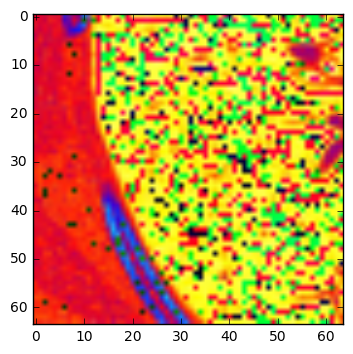

In [48]:
plt.imshow(train_img[8])
train_lab[8]

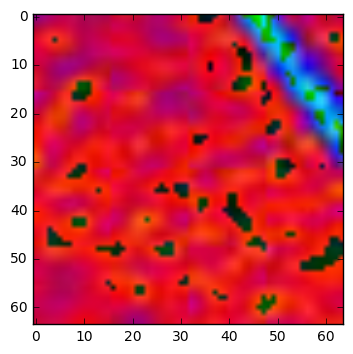

In [38]:
plt.imshow(test_img[1])